<a href="https://colab.research.google.com/github/impaex/tue-deeplearning/blob/main/tutorials/P2.2_U_net_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


#  Tutorial Contents

In this tutorial,you will learn:

(1) The U-Net structure

(2) How to build a U-net from scratch

(3) How to refactor U-net to do image segmentation


#  1. Understanding U-Net structure


The U-Net is a convolutional neural network architecture that is designed for fast and precise segmentation of images. it is one of the most popular end-to-end architectures in the field of semantic segmentation.

:<center><img src="https://raw.githubusercontent.com/vlamen/tue-deeplearning/main/img/unet.png" alt="Unet architecture" width="500"/></center>

From the paper [[1]](https://arxiv.org/pdf/1505.04597.pdf,),

The network architecture is illustrated in Fig-1. It consists of a contracting path (left side), an expanding path (right side) and skip connections (horizontal connections depicted in gray).


**[1]U-Net: Convolutional Networks for Biomedical Image Segmentation**


The contracting path follows the typical architecture of a convolutional network. Its goal is to develop a global representation of the image as a series of contractions of larger and larger neighborhoods. The contracting path captures features at different scales of the images by using a traditional stack of convolutional and max pooling layers. Concretely speaking, a block in the encoder consists of the repeated use of two convolutional layers (k=3, s=1), each followed by a non-linearity layer, and a max-pooling layer (k=2, s=2). For every convolution block and its associated max pooling operation, the number of feature maps is doubled to ensure that the network can learn the complex structures effectively.

The expanding path is symmetric counterpart to the contraction. Its role is to distribute and mix the information that comes from the global features and the local details given by the skip connections. This path uses transposed convolutions. This type of convolutional layer is an up-sampling method with trainable parameters and performs the reverse of (down)pooling layers such as the max pool. Each convolution block is followed by an up-convolutional layer. The number of feature maps is halved in every block. Because recreating a segmentation mask from a small feature map is a rather difficult task for the network, the output after every up-convolutional layer is appended by the feature maps of the corresponding encoder block. The feature maps of the encoder layer are cropped if the dimensions exceed the one of the corresponding decoder layers.

# 2. Building a U-net from scratch

Let’s start to now turn this simple structure to PyTorch Code

## Building Conv Block

We will need two Conv2D operations with ReLU activation in both contracting path  and expanding path. The Convolution operations have kernel size of 3, and no padding. Therefore, the output feature map doesn’t have the same Height and Width as the input feature map.  Batch normalization is introduced to increase the speed at which networks train and make weights easier to initialize.

From the paper [[1]](https://arxiv.org/pdf/1505.04597.pdf,):


*The contractive path consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.*


Let’s write Block in code.

In [2]:
import torch.nn as nn
import torch
class  Block(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

That’s simple - two convolution operations, one that doubles the number of channels from `in_channels` to `out_channels` and another that goes from `out_channels` to `out_channels`. Both are 2D convolutions with kernel size 3 and no padding as mentioned in the paper followed by `BatchNorm2d` and `ReLU` activation.

Let’s make sure this works.

In [3]:
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 572, 572)
enc_block(x).shape


torch.Size([1, 64, 568, 568])

So this is looking good, the output size matches that in `fig-1` top-left. Given an input image with shape `1x572x572` the output is of shape `64x568x568`.

## The Encoder

Now we are ready to implement the Encoder. The Encoder is the contractive path of the U-Net Architecture.

So far we have implemented the convolution operations but not the downsampling part. As mentioned in the paper:

*Each block is followed by a 2x2 max pooling operation with stride 2 for downsampling*


So that’s all we need to do, we need add `MaxPooling` operation  that is performed between two Block operations.

In [4]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


That’s all we have done. On the Encoder side, the encoder block or self.enc_blocks is a list of Block operations. Next, we perform the MaxPooling operation to the outputs of every block. Since, we also need to store the outputs of the block, we store them in a list called ftrs and return this list.

Let’s make sure this implementation works.

In [5]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


The output shapes exactly match the shapes mentioned in `fig-1` - so far, so good. Having implemented the `Encoder`, we are now ready to move on the `Decoder`.

## The Decoder

The Decoder, is the expanding path of the U-Net Architecture.

From the paper:

*Every step in the expanding path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution*

Note that we have already implemented the part where two 3x3 convolutions occur followed by ReLU activation in `Block`. All we need to do to implement the `Decoder` is to add the “up-convolution” and the feature concatenation with correspondingly cropped feature map from the contracting path.

In PyTorch, the `ConvTranspose2d` operation performs the “up-convolution”. It accepts parameters like `in_channels`, `out_channels`, `kernel_size` and `stride` amongst others.

Since the `in_channels` and `out_channels` values are different in the Decoder depending on where this operation is performed, in the implementation, the “up-convolution” operations are also stored as a list. Stride and kernel size are always 2 as mentioned in the paper.

Now, all we need is to perform feature concatenation. Let’s look at the implementation of the Decoder to understand how all this works more clearly -

In [6]:
import torchvision
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


So the `self.dec_blocks` is a list of `Decoder Blocks` that perform the two conv + ReLU operation as mentioned in the paper. The `self.upconvs` is a list of `ConvTranspose2d` operations that perform the “up-convolution” operations. And finally, in the `forward` function, the decoder accepts the `encoder_features` which were output by the Encoder to perform the concatenation operation before passing the result to `Block`.

That’s really all there is inside the `Decoder` of a U-Net. Let’s make sure this implementation works:

In [7]:
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

And there it is, the final feature map is of size `64x388x388` which matches that of `fig-1`. We have just successfully implemented both the Encoder and the Decoder so far.

The purpose of `ftrs[::-1][1:]` might be confusing.

Let's recall the outputs of the Encoder. They were:
```
torch.Size([1, 64, 568, 568]) #0
torch.Size([1, 128, 280, 280]) #1
torch.Size([1, 256, 136, 136]) #2
torch.Size([1, 512, 64, 64]) #3
torch.Size([1, 1024, 28, 28]) #4


```

Now, from `fig-1`, we can see that the feature map with shape `torch.Size([1, 1024, 28, 28])` is never really concatenated but only a “up-convolution” operation is performed on it. Also, the 1st Decoder block in fig-1 accepts the inputs from the 3rd position Encoder block. Similarly, the 2nd Decoder block accepts the inputs from the 2nd position Encoder block and so on. Therefore, the encoder_features' order are reversed before passing them to the Decoder and since the feature map with shape `torch.Size([1, 1024, 28, 28])` is not concatenated to the Decoder blocks, it is not passed.

Hence, the input to the decoder is `ftrs[::-1][1:]`.

## U-Net
Great, we have so far implemented both the Encoder and the Decoder of U-Net architecture. Let’s put it all together to complete our implementation of U-Net.

In [8]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=2, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

Let’s make sure this implementation works:

In [9]:
unet = UNet()
x    = torch.randn(1, 3, 572, 572)
unet(x).shape


torch.Size([1, 2, 388, 388])

The output shape matches that of `fig-1`.

# 3. Using U-net to do image segmentation

##  Data preparation

We will use a sample of the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) dataset to train the model to do image segmentation.

Let’s talk about the data first. What we would like to have is 2 directories, something like `/Input` and `/Target`. In the `/Input` directory, we find all input images and in the `/Target` directory the segmentation maps. The labels are usually encoded with pixel values, meaning that all pixels of the same class have the same pixel value e.g. background=0, others=1

Download the data in this [link](https://drive.google.com/drive/folders/1hh2QRzmyveps3C3GCDRkvRNsD5BslHIY?usp=sharing), upload to your google drive and mount to your colab

In [10]:
from google.colab import drive
!mkdir drive
drive.mount('drive')

Mounted at drive


Then we list all the data in your drive to see if we mount successfully.

In [11]:
!ls "drive/My Drive/Deeplearning Google Colab/P2.2"

Input  Target  Test


In [12]:
# modify the path according to your own file location
import pathlib

def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [str(file) for file in path.glob(ext) if file.is_file()]
    # delete duplicates
    filenames = [file for file in filenames if '(1)' not in file]
    return sorted(filenames)

# root = pathlib.Path.cwd() / 'Unet_data'
root = pathlib.Path("drive/My Drive/Deeplearning Google Colab/P2.2")
inputs = get_filenames_of_path(root / 'Input')
targets = get_filenames_of_path(root / 'Target')

Let us split the data into training and validation dataset with the ratio 0.8

In [13]:
# random seed
random_seed = 42

from sklearn.model_selection import train_test_split
# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

We can visualize some images from the training and validation dataset

training image example


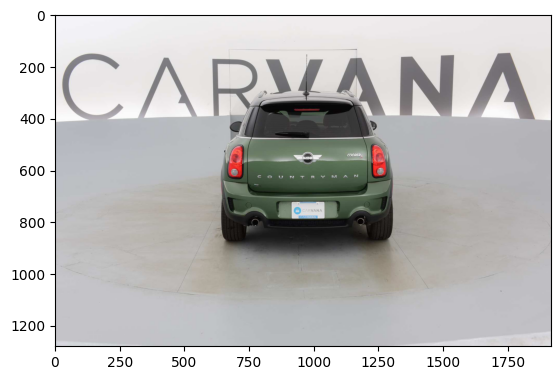

training label example


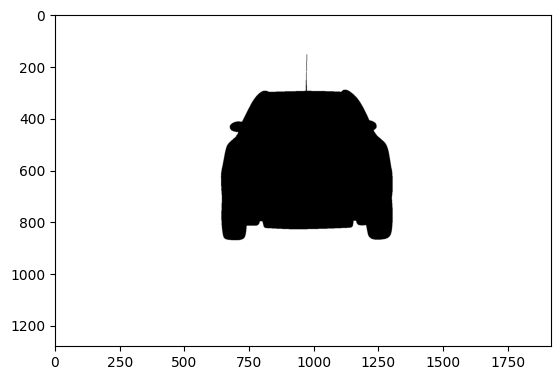

validation image example


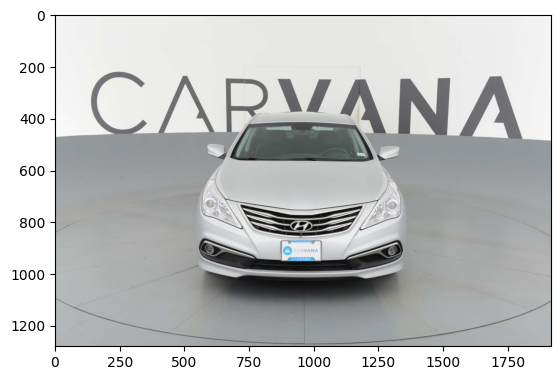

validation label example


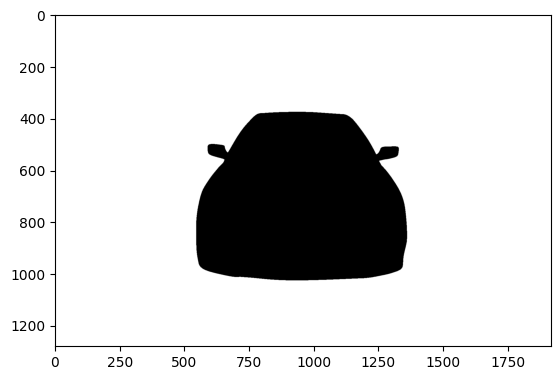

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# visualize examples of training images and labels
input_ID=0

print ("training image example")
x=Image.open(inputs_train[0])
plt.imshow(x)
plt.show()

print ("training label example")
x=Image.open(targets_train[0])
plt.imshow(x,cmap='binary')
plt.show()

print ("validation image example")
x=Image.open(inputs_valid[0])
plt.imshow(x)
plt.show()

print ("validation label example")
x=Image.open(targets_valid[0])
plt.imshow(x,cmap='binary')
plt.show()

With the help of `Dataset`, we customized the training and validation dataset. The original's image resolution is too huge that may slow down the training process, so we use `transforms.Resize` to resize the dimension to `128x128`. `transforms.ToTensor()` could help us to transfer image data to torch tensors and normalize the values to `0~1`

In [15]:

from PIL import Image
from torch.utils.data import Dataset


import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize

image_size=(128,128)

data_transform=transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    ])


class SegmentationDataSet(Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Load input and target
        x=Image.open(input_ID)
        y=Image.open(target_ID)

        # Preprocessing
        if self.transform is not None:
            x=self.transform(x).type(self.inputs_dtype)
            y=self.transform(y).type(self.targets_dtype)


        return x, torch.squeeze(y)

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=data_transform)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=data_transform)

Then we use `DataLoader` to create training and validation dataloader

In [16]:


from torch.utils.data import DataLoader

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)

## Refactor the original U-Net

The U-net we created in section 1 has depth 5, but it is not applicable in our case. Because we are now dealing with images with pixel `128x128x3`,  the output dimensions of the decoder block would be too small after several pooling layers. Try the following codes, and you will see an error like:

```RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size```


In [17]:
# Could raise error

unet = UNet()
x    = torch.randn(1, 3, 128, 128)
unet(x).shape

RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

Therefore, we need to reduce the depth, let's try depth=4

In [18]:
enc_chs=(3,64,128,256,512)
dec_chs=(512, 256, 128, 64)

unet = UNet(enc_chs,dec_chs)

x    = torch.randn(1, 3, 128, 128)
unet(x).shape

torch.Size([1, 2, 36, 36])

We could also notice that in the original U-net, the output dimension is not the same as the input dimension. However, this is not the case with our data. Therefore, we need to use [`padding`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) in the `Block` to make sure outputs and inputs have the same dimensions.

In [20]:

class  Block(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()


        # use padding to adjust the output dimension
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [21]:
enc_chs=(3,64,128,256,512)
dec_chs=(512, 256, 128, 64)

unet = UNet(enc_chs,dec_chs)

x    = torch.randn(1, 3, 128, 128)
unet(x).shape

torch.Size([1, 2, 128, 128])

Now, the outputs have the same dimention with the inputs,`128x128`

## Train the model

Next let's train the model. First, we creat some the `Trainer` class

In [22]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):



            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)



            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')




Let's train the model, don't forget to move your model to GPU . Loss value should decrease along with epochs

In [23]:


# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')



model=unet.to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  epochs=4)

# start training
trainer.run_trainer()

 25%|██▌       | 1/4 [01:36<04:49, 96.36s/it]

EPOCH: 1/4 LOSS: 0.4070 VAL-LOSS: 0.3898


 50%|█████     | 2/4 [01:44<01:29, 44.52s/it]

EPOCH: 2/4 LOSS: 0.2702 VAL-LOSS: 0.2331


 75%|███████▌  | 3/4 [01:52<00:27, 27.63s/it]

EPOCH: 3/4 LOSS: 0.1918 VAL-LOSS: 0.1811


100%|██████████| 4/4 [02:00<00:00, 30.01s/it]

EPOCH: 4/4 LOSS: 0.1300 VAL-LOSS: 0.1065


## Plot the segmentation

We have three test images apart from the training and validation dataset, lets use the trained model to make predictions on these test images.

In [24]:
# test input and  test target files
# modify the path according to your own file location

Test_root = root / 'Test'
images_names = get_filenames_of_path(Test_root / 'Input')
targets_names = get_filenames_of_path(Test_root / 'Target')


 image index 0
original image


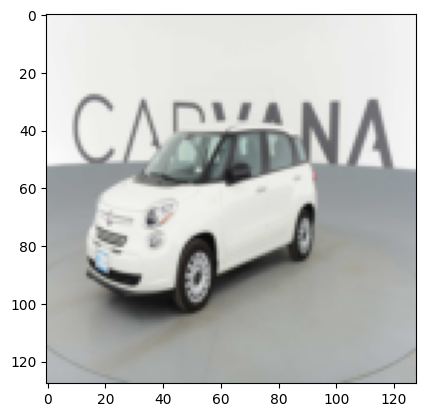

label image


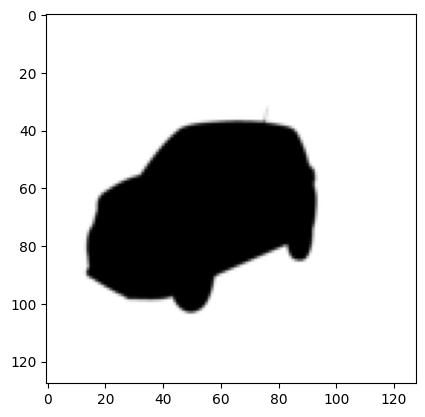

prediction


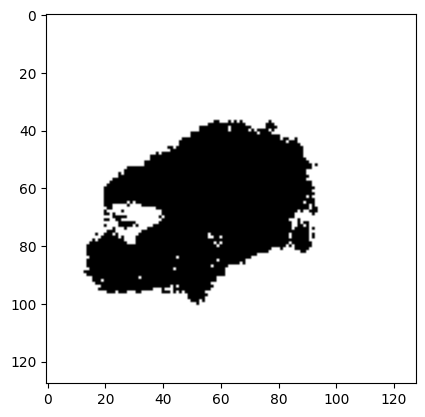


 image index 1
original image


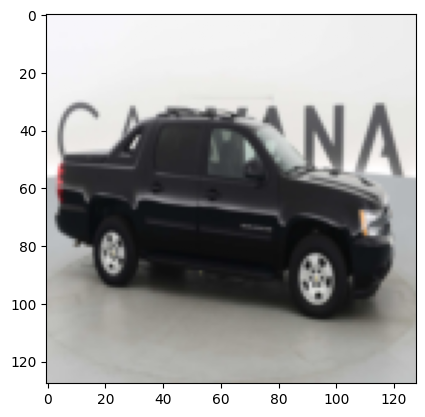

label image


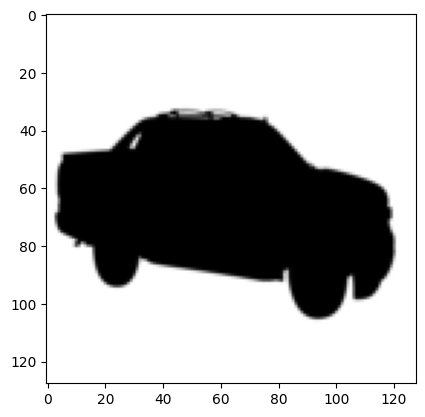

prediction


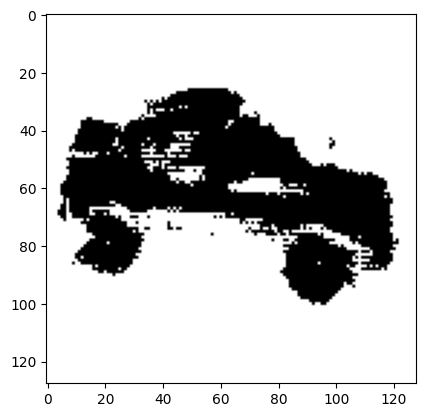


 image index 2
original image


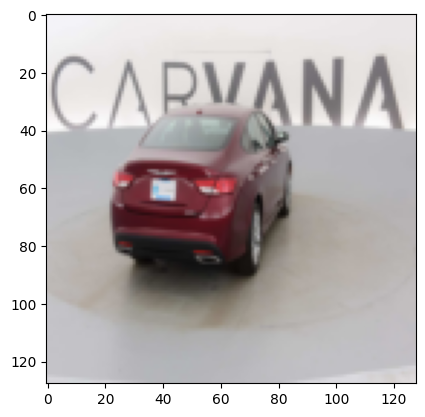

label image


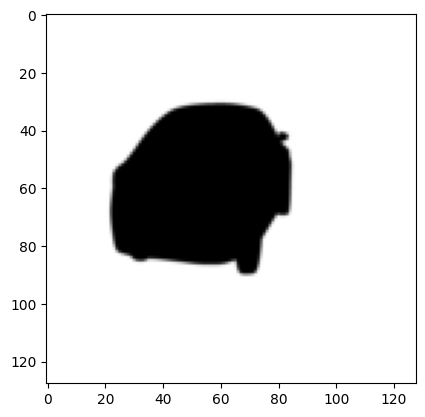

prediction


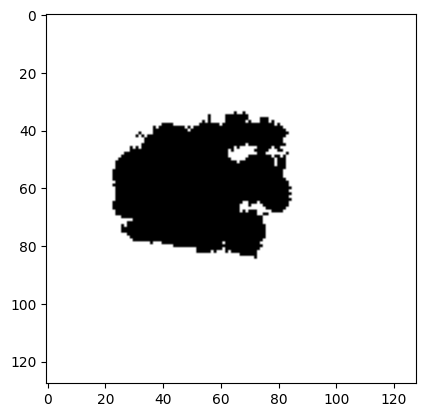

In [25]:


for index in range(len(images_names)):
    print ("\n","image index",index)
    # Show original image
    ori_image=Image.open(images_names[index])
    print ("original image")
    ori_image=data_transform(ori_image)
    t_ori_image=ori_image.permute(1,2,0)

    plt.imshow(t_ori_image)
    plt.show()


    # Show label image
    label_img=Image.open(targets_names[index])
    print ("label image")
    label_img=data_transform(label_img)
    label_img=torch.squeeze(label_img)# squeeze the data
    plt.imshow(label_img,cmap='binary')
    plt.show()


    # make predition and show prediction image
    x=torch.unsqueeze(ori_image,0)# add batch dimension [B, C, H, W]


    model.eval()
    with torch.no_grad():
        out = model(x.to(device))  # send through model/network
    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs

    img = torch.argmax(out_softmax, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    print ("prediction")
    plt.imshow(img,cmap='binary')
    plt.show()

references:

1) https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

2) https://amaarora.github.io/2020/09/13/unet.html

3) https://github.com/milesial/Pytorch-UNet